#                                 Capstone Project Coursera- The Battle of Neighborhoods 

### Introduction

I have had an offshore internship last summer in the city of Hsinchu, Taiwan at National Tsing Hua University under the guidance of Prof. Soo. Though I have had the best experience which I could have at this stage of life but one thing which I missed a lot was Indian-spicy foods.This is the only factor which kept on haunting me all the time during my stay over there.There were no true-Indian rasoi i could locate outside the campus of Tsing Hua but had only one indian rasoi in the campus with similar true-indian taste. They saved my life. I do not want to have the similar experience w.r.t foods when I visit sometime at different part of the world. With the knowledge I have gathered from the course, I am proceding to make my fingures dirty by coading a bunch of line which would give me the right location of true-indian rasoi using location data.

Since I could not find any relevent data source on Hsinchu city, I am going to utilise New york city data for the same. As part of this project , I'll list and visualize all major parts of New York City that has great indian resturants/rasoi.


### Data

New York City Data:


1. Data source : https://cocl.us/new_york_dataset  |
2. Description : This data contains all the required informations  |
3. Data source : Fousquare API  |
4. Description : I will get all the venues that we I filter these venues to get only indian resturants.



### Approach


I'll collect the new york city data from https://cocl.us/new_york_dataset and using FourSquare API I will find all venues for each neighborhood. Filtering out all venues that have Indian Rasoi, I'll analyse rating , tips and like count for each of the Rasoi. I will sort that data and visualize the ranking of neighborhoods using folium library(python)

### Questions :

Which is/are the best place/s to stay in the NY city if I prefer Indian foods ?

### Analysis


Imported all the required libraries and modules to handle data pre and post processing. 

In [4]:
import pandas as pd
import numpy as np
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)
import requests
from bs4 import BeautifulSoup
#!pip install geocoder #uncomment if the module isn't installed
import geocoder
import os
#!pip install folium #uncomment if the module isn't installed
import folium # map rendering library
from geopy.geocoders import Nominatim # convert an address into latitude and longitude values
# Matplotlib and associated plotting modules
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import matplotlib.colors as colors
%matplotlib inline


print('Libraries imported.')

     |████████████████████████████████| 92kB 18.1MB/s eta 0:00:01
Libraries imported.


Define Foursquare Credentials and Version

In [28]:
CLIENT_ID = '3YOTO33YQWCFQ01KMGHMU41G4JHVWCAWSZL1BBOP2XG0UE14' # my Foursquare ID
CLIENT_SECRET = 'YEPB21NO4J3RWRNXVJFTOGEBICRGLCHDCQZS5WOWLDMDFGOC' # my Foursquare Secret
VERSION = '20180605' # Foursquare API version

function to get the geocodes i.e latitude and longitude of a given location using geopy.

In [5]:

def geo_location(address):
    geolocator = Nominatim(user_agent="ny_explorer")
    location = geolocator.geocode(address)
    latitude = location.latitude
    longitude = location.longitude
    return latitude,longitude

function to intract with FourSquare API and get top 50 venues within a radius of 2000 metres for a given latitude and longitude. Below function will return us the venue id , venue name and category.

In [29]:
def get_venues(lat,lng):
    
    #set variables
    radius=2000
    LIMIT=50
    
    #url to fetch data from foursquare api
    url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION, 
            lat, 
            lng, 
            radius, 
            LIMIT)
    
    # get all the data
    results = requests.get(url).json()
    venue_data=results["response"]['groups'][0]['items']
    venue_details=[]
    for row in venue_data:
        try:
            venue_id=row['venue']['id']
            venue_name=row['venue']['name']
            venue_category=row['venue']['categories'][0]['name']
            venue_details.append([venue_id,venue_name,venue_category])
        except KeyError:
            pass
        
    column_names=['ID','Name','Category']
    df = pd.DataFrame(venue_details,columns=column_names)
    return df

Function to get venue details like like count , rating , tip counts for a given venue id. This will be used for ranking.

In [30]:
def get_venue_details(venue_id):
        
    
    #url to fetch data from foursquare api
    url = 'https://api.foursquare.com/v2/venues/{}?&client_id={}&client_secret={}&v={}'.format(
            venue_id,
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION)
    
    # get all the data
    results = requests.get(url).json()
    venue_data=results['response']['venue']
    venue_details=[]
    try:
        venue_id=venue_data['id']
        venue_name=venue_data['name']
        venue_likes=venue_data['likes']['count']
        venue_rating=venue_data['rating']
        venue_tips=venue_data['tips']['count']
        venue_details.append([venue_id,venue_name,venue_likes,venue_rating,venue_tips])
    except KeyError:
        pass
        
    column_names=['ID','Name','Likes','Rating','Tips']
    df = pd.DataFrame(venue_details,columns=column_names)
    return df

Funtion to get the new york city data such as Boroughs, Neighborhoods along with their latitude and longitude.



In [31]:
def get_new_york_data():
    url='https://cocl.us/new_york_dataset'
    resp=requests.get(url).json()
    # all data is present in features label
    features=resp['features']
    
    # define the dataframe columns
    column_names = ['Borough', 'Neighborhood', 'Latitude', 'Longitude'] 
    # instantiate the dataframe
    new_york_data = pd.DataFrame(columns=column_names)
    
    for data in features:
        borough = data['properties']['borough'] 
        neighborhood_name = data['properties']['name']
        
        neighborhood_latlon = data['geometry']['coordinates']
        neighborhood_lat = neighborhood_latlon[1]
        neighborhood_lon = neighborhood_latlon[0]
    
        new_york_data = new_york_data.append({'Borough': borough,
                                          'Neighborhood': neighborhood_name,
                                          'Latitude': neighborhood_lat,
                                          'Longitude': neighborhood_lon}, ignore_index=True)
    
    return new_york_data


Call the above funtion to get the NY city data.

In [32]:
new_york_data=get_new_york_data()

In [33]:
new_york_data.head()

,Borough,Neighborhood,Latitude,Longitude
0,Bronx,Wakefield,40.894705,-73.847201
1,Bronx,Co-op City,40.874294,-73.829939
2,Bronx,Eastchester,40.887556,-73.827806
3,Bronx,Fieldston,40.895437,-73.905643
4,Bronx,Riverdale,40.890834,-73.912585


In [34]:
#how many neighbourhood are there to the NY city?
new_york_data.shape

(306, 4)

Which Borough has the most number of neighbourhood ?

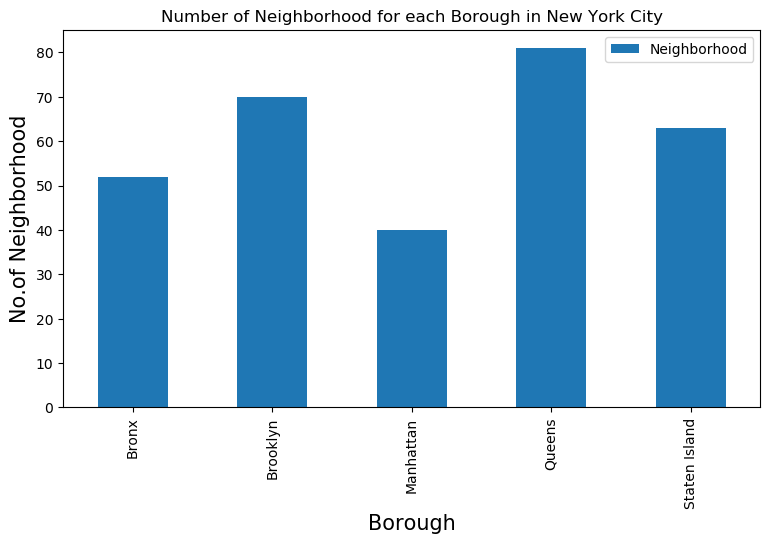

In [35]:
plt.figure(figsize=(9,5), dpi = 100)
# title
plt.title('Number of Neighborhood for each Borough in New York City')
#On x-axis
plt.xlabel('Borough', fontsize = 15)
#On y-axis
plt.ylabel('No.of Neighborhood', fontsize=15)
#giving a bar plot
new_york_data.groupby('Borough')['Neighborhood'].count().plot(kind='bar')
#legend
plt.legend()
#displays the plot
plt.show()

### Let's collect the Indian Rasoi for each of the Neighbourhood

In [36]:
column_names=['Borough', 'Neighborhood', 'ID','Name']
indian_rest_ny=pd.DataFrame(columns=column_names)
count=1
for row in new_york_data.values.tolist():
    Borough, Neighborhood, Latitude, Longitude=row
    venues = get_venues(Latitude,Longitude)
    indian_resturants=venues[venues['Category']=='Indian Restaurant']   
    print('(',count,'/',len(new_york_data),')','Indian Resturants in '+Neighborhood+', '+Borough+':'+str(len(indian_resturants)))
    for resturant_detail in indian_resturants.values.tolist():
        id, name , category=resturant_detail
        indian_rest_ny = indian_rest_ny.append({'Borough': Borough,
                                                'Neighborhood': Neighborhood, 
                                                'ID': id,
                                                'Name' : name
                                               }, ignore_index=True)
    count+=1

( 1 / 306 ) Indian Resturants in Wakefield, Bronx:1
( 2 / 306 ) Indian Resturants in Co-op City, Bronx:0
( 3 / 306 ) Indian Resturants in Eastchester, Bronx:0
( 4 / 306 ) Indian Resturants in Fieldston, Bronx:0
( 5 / 306 ) Indian Resturants in Riverdale, Bronx:0
( 6 / 306 ) Indian Resturants in Kingsbridge, Bronx:0
( 7 / 306 ) Indian Resturants in Marble Hill, Manhattan:0
( 8 / 306 ) Indian Resturants in Woodlawn, Bronx:1
( 9 / 306 ) Indian Resturants in Norwood, Bronx:0
( 10 / 306 ) Indian Resturants in Williamsbridge, Bronx:0
( 11 / 306 ) Indian Resturants in Baychester, Bronx:0
( 12 / 306 ) Indian Resturants in Pelham Parkway, Bronx:0
( 13 / 306 ) Indian Resturants in City Island, Bronx:0
( 14 / 306 ) Indian Resturants in Bedford Park, Bronx:0
( 15 / 306 ) Indian Resturants in University Heights, Bronx:0
( 16 / 306 ) Indian Resturants in Morris Heights, Bronx:0
( 17 / 306 ) Indian Resturants in Fordham, Bronx:0
( 18 / 306 ) Indian Resturants in East Tremont, Bronx:0
( 19 / 306 ) Ind

In [37]:
indian_rest_ny.head()


,Borough,Neighborhood,ID,Name
0,Bronx,Wakefield,4c0448d9310fc9b6bf1dc761,Curry Spot
1,Bronx,Woodlawn,4c0448d9310fc9b6bf1dc761,Curry Spot
2,Brooklyn,Bay Ridge,4b5a4dc8f964a520a2bb28e3,Taj Mahal
3,Brooklyn,Brighton Beach,4af0d31bf964a5207ddf21e3,Pak Nasheman
4,Brooklyn,Crown Heights,51f70290498e7aa5c9f47324,India House


How many indian Rasoi is/are there in NY city ?

In [38]:
indian_rest_ny.shape

(100, 4)

Which Borough has the maximum number of Indian Rasoi ?

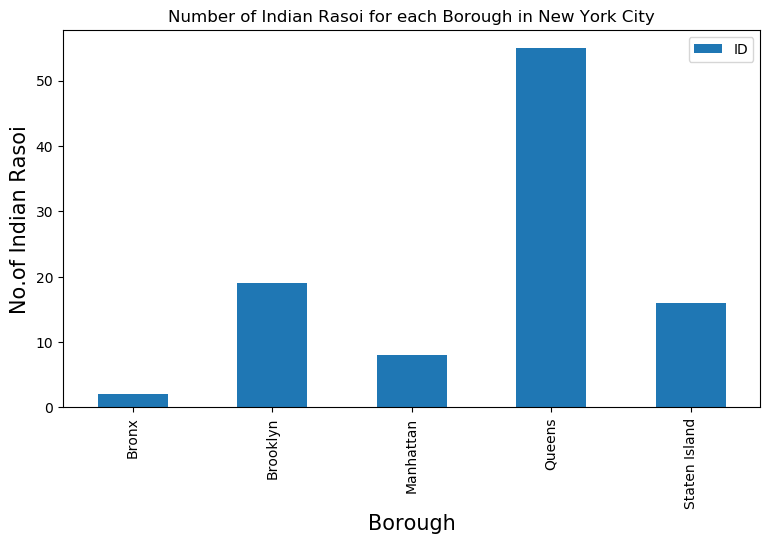

In [40]:
plt.figure(figsize=(9,5), dpi = 100)
# title
plt.title('Number of Indian Rasoi for each Borough in New York City')
#On x-axis
plt.xlabel('Borough', fontsize = 15)
#On y-axis
plt.ylabel('No.of Indian Rasoi', fontsize=15)
#giving a bar plot
indian_rest_ny.groupby('Borough')['ID'].count().plot(kind='bar')
#legend
plt.legend()
#displays the plot
plt.show()

In [ ]:
Which neighbourhood has the maximum number of Indian Rasoi ?

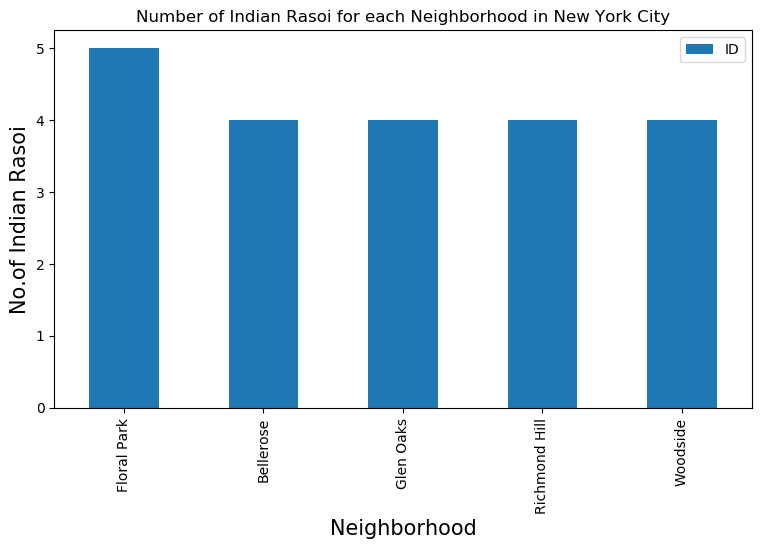

In [41]:

plt.figure(figsize=(9,5), dpi = 100)
# title
plt.title('Number of Indian Rasoi for each Neighborhood in New York City')
#On x-axis
plt.xlabel('Neighborhood', fontsize = 15)
#On y-axis
plt.ylabel('No.of Indian Rasoi', fontsize=15)
#giving a bar plot
indian_rest_ny.groupby('Neighborhood')['ID'].count().nlargest(5).plot(kind='bar')
#legend
plt.legend()
#displays the plot
plt.show()

In [42]:
indian_rest_ny[indian_rest_ny['Neighborhood']=='Floral Park']

,Borough,Neighborhood,ID,Name
59,Queens,Floral Park,4e4e3e22bd4101d0d7a5c2d1,Kerala Kitchen
60,Queens,Floral Park,527ffc0811d2d329d5e49abd,Jackson Diner
61,Queens,Floral Park,4b647b56f964a520c4b62ae3,Usha Foods & Usha Sweets
62,Queens,Floral Park,4b787c49f964a5209cd12ee3,Santoor Indian Restaurant
63,Queens,Floral Park,4c0c01e0bbc676b00d6b4cd5,Mumbai Xpress


Therefore, Floral Park in Queens has maximum of Indian Rasoin. total of 5 

### Let's see likes, ratings and tips

In [43]:
# prepare neighborhood list that contains indian resturants
column_names=['Borough', 'Neighborhood', 'ID','Name','Likes','Rating','Tips']
indian_rest_stats_ny=pd.DataFrame(columns=column_names)
count=1


for row in indian_rest_ny.values.tolist():
    Borough,Neighborhood,ID,Name=row
    try:
        venue_details=get_venue_details(ID)
        print(venue_details)
        id,name,likes,rating,tips=venue_details.values.tolist()[0]
    except IndexError:
        print('No data available for id=',ID)
        # we will assign 0 value for these resturants as they may have been 
        #recently opened or details does not exist in FourSquare Database
        id,name,likes,rating,tips=[0]*5
    print('(',count,'/',len(indian_rest_ny),')','processed')
    indian_rest_stats_ny = indian_rest_stats_ny.append({'Borough': Borough,
                                                'Neighborhood': Neighborhood, 
                                                'ID': id,
                                                'Name' : name,
                                                'Likes' : likes,
                                                'Rating' : rating,
                                                'Tips' : tips
                                               }, ignore_index=True)
    count+=1

                         ID        Name  Likes  Rating  Tips
0  4c0448d9310fc9b6bf1dc761  Curry Spot      4     7.7    11
( 1 / 100 ) processed
                         ID        Name  Likes  Rating  Tips
0  4c0448d9310fc9b6bf1dc761  Curry Spot      4     7.7    11
( 2 / 100 ) processed
                         ID       Name  Likes  Rating  Tips
0  4b5a4dc8f964a520a2bb28e3  Taj Mahal     38     8.3    26
( 3 / 100 ) processed
                         ID          Name  Likes  Rating  Tips
0  4af0d31bf964a5207ddf21e3  Pak Nasheman      9     7.4     4
( 4 / 100 ) processed
                         ID         Name  Likes  Rating  Tips
0  51f70290498e7aa5c9f47324  India House     29     8.9     5
( 5 / 100 ) processed
                         ID          Name  Likes  Rating  Tips
0  512a9ea9e4b004fb8eeb84e5  Silver Krust     12     8.1     3
( 6 / 100 ) processed
                         ID         Name  Likes  Rating  Tips
0  51f70290498e7aa5c9f47324  India House     29     8.9     5
( 7 

KeyError: 'venue'

In [44]:
indian_rest_stats_ny.head()

,Borough,Neighborhood,ID,Name,Likes,Rating,Tips
0,Bronx,Wakefield,4c0448d9310fc9b6bf1dc761,Curry Spot,4,7.7,11
1,Bronx,Woodlawn,4c0448d9310fc9b6bf1dc761,Curry Spot,4,7.7,11
2,Brooklyn,Bay Ridge,4b5a4dc8f964a520a2bb28e3,Taj Mahal,38,8.3,26
3,Brooklyn,Brighton Beach,4af0d31bf964a5207ddf21e3,Pak Nasheman,9,7.4,4
4,Brooklyn,Crown Heights,51f70290498e7aa5c9f47324,India House,29,8.9,5


In [45]:
indian_rest_stats_ny.shape

(45, 7)

In [46]:
indian_rest_ny.shape

(100, 4)

In [50]:
indian_rest_stats_ny_csv.head()


,Borough,Neighborhood,ID,Name,Likes,Rating,Tips
0,Bronx,Wakefield,4c0448d9310fc9b6bf1dc761,Curry Spot,4,7.7,11
1,Bronx,Woodlawn,4c0448d9310fc9b6bf1dc761,Curry Spot,4,7.7,11
2,Brooklyn,Bay Ridge,4b5a4dc8f964a520a2bb28e3,Taj Mahal,38,8.3,26
3,Brooklyn,Brighton Beach,4af0d31bf964a5207ddf21e3,Pak Nasheman,9,7.4,4
4,Brooklyn,Crown Heights,51f70290498e7aa5c9f47324,India House,29,8.9,5


In [51]:
indian_rest_stats_ny.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 45 entries, 0 to 44
Data columns (total 7 columns):
Borough         45 non-null object
Neighborhood    45 non-null object
ID              45 non-null object
Name            45 non-null object
Likes           45 non-null object
Rating          45 non-null float64
Tips            45 non-null object
dtypes: float64(1), object(6)
memory usage: 2.5+ KB


### Convert likes and tips into float for further analysis


In [52]:
indian_rest_stats_ny['Likes']=indian_rest_stats_ny['Likes'].astype('float64')
indian_rest_stats_ny['Tips']=indian_rest_stats_ny['Tips'].astype('float64')
indian_rest_stats_ny.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 45 entries, 0 to 44
Data columns (total 7 columns):
Borough         45 non-null object
Neighborhood    45 non-null object
ID              45 non-null object
Name            45 non-null object
Likes           45 non-null float64
Rating          45 non-null float64
Tips            45 non-null float64
dtypes: float64(3), object(4)
memory usage: 2.5+ KB


### Let's seet the Neighbourhood with maximum average rating of Rasoi

In [54]:
ny_neighborhood_stats=indian_rest_stats_ny.groupby('Neighborhood',as_index=False).mean()[['Neighborhood','Rating']]
ny_neighborhood_stats.columns=['Neighborhood','Average Rating']
ny_neighborhood_stats.sort_values(['Average Rating'],ascending=False).head(10)

,Neighborhood,Average Rating
24,Tribeca,9.1
23,Sunnyside,9.0
16,Long Island City,9.0
0,Astoria,8.9
3,Bedford Stuyvesant,8.9
8,Crown Heights,8.9
11,Fort Greene,8.7
20,Prospect Park South,8.7
19,Prospect Lefferts Gardens,8.7
7,Clinton Hill,8.7


### Let's seet the Borough with maximum average rating of Rasoi

In [55]:
ny_borough_stats=indian_rest_stats_ny.groupby('Borough',as_index=False).mean()[['Borough','Rating']]
ny_borough_stats.columns=['Borough','Average Rating']
ny_borough_stats.sort_values(['Average Rating'],ascending=False).head()

,Borough,Average Rating
1,Brooklyn,8.383333
2,Manhattan,8.266667
3,Queens,8.068000
0,Bronx,7.700000


Let's dig a little dipper

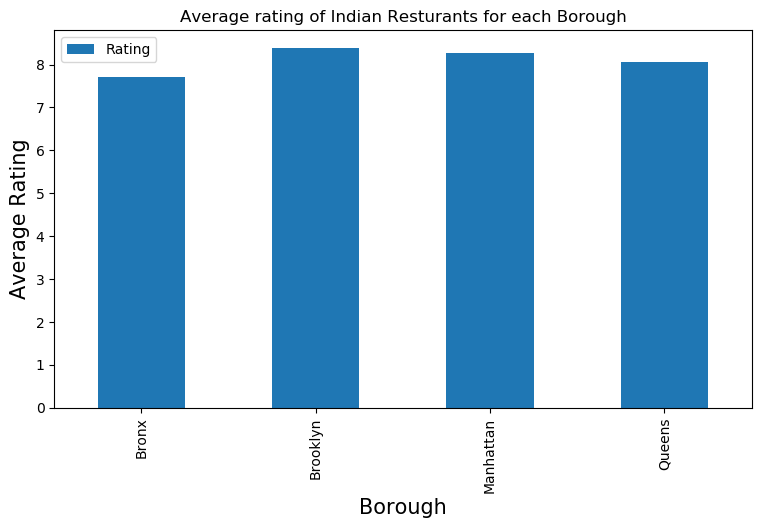

In [56]:
plt.figure(figsize=(9,5), dpi = 100)
# title
plt.title('Average rating of Indian Resturants for each Borough')
#On x-axis
plt.xlabel('Borough', fontsize = 15)
#On y-axis
plt.ylabel('Average Rating', fontsize=15)
#giving a bar plot
indian_rest_stats_ny.groupby('Borough').mean()['Rating'].plot(kind='bar')
#legend
plt.legend()
#displays the plot
plt.show()

I would like to stay in the neighbourhood with rating more than 9 :)

In [57]:
ny_neighborhood_stats=ny_neighborhood_stats[ny_neighborhood_stats['Average Rating']>=9.0]
ny_neighborhood_stats

,Neighborhood,Average Rating
16,Long Island City,9.0
23,Sunnyside,9.0
24,Tribeca,9.1


Let's get the lonitude and latitude of the area

In [58]:
ny_neighborhood_stats=pd.merge(ny_neighborhood_stats,new_york_data, on='Neighborhood')
ny_neighborhood_stats=ny_neighborhood_stats[['Borough','Neighborhood','Latitude','Longitude','Average Rating']]
ny_neighborhood_stats

,Borough,Neighborhood,Latitude,Longitude,Average Rating
0,Queens,Long Island City,40.750217,-73.939202,9.0
1,Queens,Sunnyside,40.740176,-73.926916,9.0
2,Staten Island,Sunnyside,40.612760,-74.097126,9.0
3,Manhattan,Tribeca,40.721522,-74.010683,9.1


Let's put everything on the map and visualise the Neighbourhood :)

In [59]:
ny_map = folium.Map(location=geo_location('New York'), zoom_start=12)
# instantiate a feature group for the incidents in the dataframe
incidents = folium.map.FeatureGroup()

# loop through the 100 crimes and add each to the incidents feature group
for lat, lng, in ny_neighborhood_stats[['Latitude','Longitude']].values:
    incidents.add_child(
        folium.CircleMarker(
            [lat, lng],
            radius=10, # define how big you want the circle markers to be
            color='yellow',
            fill=True,
            fill_color='blue',
            fill_opacity=0.6
        )
    )

Isn't labeling Important ?

In [77]:
ny_neighborhood_stats['Label']=ny_neighborhood_stats['Neighborhood']+', '+ny_neighborhood_stats['Borough']+'('+ny_neighborhood_stats['Average Rating'].map(str)+')'
# add pop-up text to each marker on the map
for lat, lng, label in ny_neighborhood_stats[['Latitude','Longitude','Label']].values:
    folium.Marker([lat, lng], popup=label).add_to(ny_map)        
# add incidents to map
ny_map.add_child(incidents)


### save the map

In [78]:
ny_map.save('Neighbourhood_rating.html')

# Conclusion 

1. Long Island City - Queens, Sunnyside - Queens, Sunnyside - Staten Island are some of the best neighborhoods for indian rasoi.
2. Brooklyn have potential Indian Rasoi Market/
3. Bronx ranks last in average rating of Indian Resturants.
4. Brooklyn is the best place to stay if you prefer Indian Rasoi.

# Limitation/s :

The accuracy is dependent on the data provided by FourSquare and the ranking is dependent on the user ratings.